In [ ]:
#!pip install qiskit
#!pip install qiskit_aer
#!pip install qiskit_machine_learning
#!pip install qiskit_algorithms
#!pip install matplotlib
#!pip install pylatexenc
#!pip install scipy
#!pip install -U scikit-learn

#!git clone https://github.com/IsaVia777/atelier_qml.git

# Lab 2: Encodage de données

**Objectifs:**
* Projection de données 1D dans un espace des caractéristiques quantiques avec l’encodage par angle
* Encodage par angle et par amplitude pour le jeu de données Iris
* Encodage de données avec Qiskit


In [1]:
import numpy as np 
import matplotlib.pyplot as plt
#import os 
#import sys

from qiskit_aer import Aer
from qiskit.circuit import Parameter
from qiskit.circuit.library import ZFeatureMap, ZZFeatureMap, PauliFeatureMap
from qiskit.quantum_info import Statevector
from qiskit_machine_learning.circuit.library import RawFeatureVector

SEED = 8398

In [2]:
#import sys
#sys.path.insert(0, '/content/atelier_qml')

from utils import *

In [3]:
# Les simulateurs qui seront utilisés dans ce laboratoire
qasm_sim = Aer.get_backend('qasm_simulator')
sv_sim = Aer.get_backend('statevector_simulator')

### Ensemble de données 1D non linéairement séparable

In [4]:
x0,x1 = get_non_seperable_data()
nb_features = 1

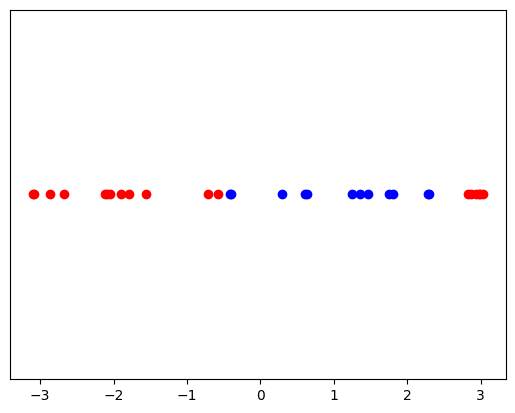

In [5]:
# Aperçu de l'ensemble de données. Étiquette 0 en bleu, étiquette 1 en rouge
plt.yticks([])
plt.scatter(x0, [0]*len(x0), color='blue')
plt.scatter(x1, [0]*len(x1), color='red')

On ne peut pas séparer la classe *bleu* de la classe *rouge* en traçant une droite.<br>
On dit que les données ne sont pas *linéairement séparables*.<br>
L'encodage des données dans un espace des caractéristiques quantiques va nous permettre de rendre les données séparables!

## Encodage des données

On encode les données dans un état quantique à l'aide d'une **projection dans l'espace des caractéristiques quantiques** $\phi(\mathbf{x})$.<br>

### Encodage par angle
On doit définir un circuit quantique paramétré. Ces paramètres seront utilisés pour charger les données.


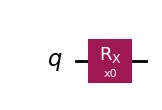

In [6]:
# Créer une liste de paramètres.
# Puisque les données sont 1D, on n'a besoin que d'un seul paramètre
x_params = [Parameter(f'x{str(i)}') for i in range(nb_features)]

# Instancier le circuit quantique
qc = QuantumCircuit(nb_features)

for i in range(nb_features):
    # Encodage à l'aide d'une rotation RX
    qc.rx(x_params[i], i)

qc.draw('mpl')

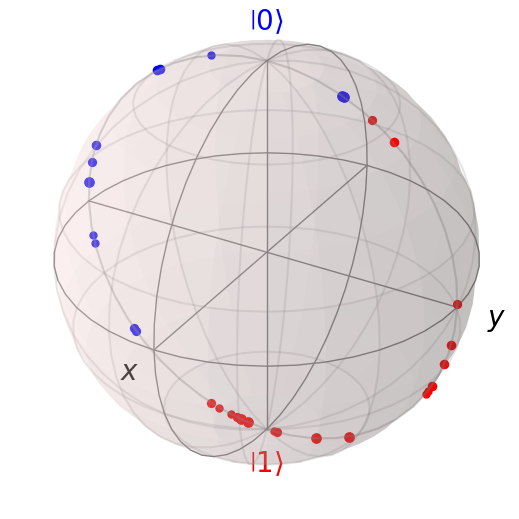

In [7]:
# Obtenir le vecteur d'état correspondant à chacun des points de notre ensemble de données
statevectors0 = get_statevector(qc, x0, x_params, sv_sim)
statevectors1 = get_statevector(qc, x1, x_params, sv_sim)

# Visualisation de l'ensemble de données sur la sphère de Bloch
plot_bloch_visualization([statevectors0, statevectors1], ['b', 'r'])

### Encodage par angle de l'ensemble de données Iris

In [8]:
x_train,y_train,x_test,y_test = get_iris(SEED)
nb_features = 4
x_train[0]

array([0.776114  , 0.54974742, 0.30721179, 0.03233808])

On définit une fonction qui prend en paramètre un circuit quantique et un vecteur de caractéristiques ou de paramètres et qui procède à l'**encodage par angle** du vecteur.

In [9]:
def angle_embedding(qc, feature_vec):  
    
    """
    Encodage par angle avec des portes RX.

    :param qc: Le circuit quantique.
    :param feature_vec: Le vecteur de paramètres utilisés pour charger les données.
                        Le nombre de qubit dans le circuit devrait être égal 
                        aux nombres de caractéristiques dans le vecteur de données
    :return: Le circuit quantique auquel on a ajouté une couche d'encodage par angle. 
    """
    if qc.num_qubits != len(feature_vec):
        raise ValueError('Le nombre de caractéristiques doit être égal au nombre de qubits.')

    for i in range(qc.num_qubits):
        qc.rx(feature_vec[i], i)

    return qc

Visualisation du circuit permettant l'encodage d'une donnée par angle

Premier élément de l'ensemble d'entraînement: [0.776114   0.54974742 0.30721179 0.03233808]


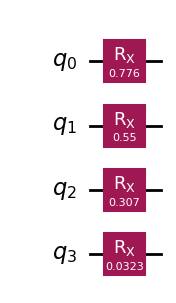

In [10]:
print("Premier élément de l'ensemble d'entraînement:", x_train[0])

nb_qubits = nb_features
qc = QuantumCircuit(nb_qubits)
qc = angle_embedding(qc, x_train[0])

qc.draw("mpl")

### Encodage par amplitude

Encodage d'un vecteur hypothétique: 

($\frac{1}{\sqrt{2}}$, 0, 0, $\frac{1}{\sqrt{2}}$)

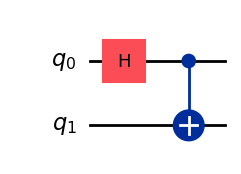

In [11]:
qc = QuantumCircuit(2)
qc.h(0)
qc.cx(0,1)
qc.draw('mpl')

Dans ce cas-ci, c'est simple, le vecteur d'état correspondant est celui d'une paire de Bell!<br>
De façon générale, trouver le circuit quantique permettant d'encoder une donnée par amplitude n'est pas trivial.<br>
Heureusement, Qiskit offre la classe __[RawFeatureVector](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.circuit.library.RawFeatureVector.html)__ qui permet d'effectuer l'encodage par amplitude.

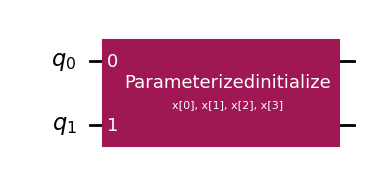

In [12]:
qc = RawFeatureVector(nb_features) 
qc.draw('mpl')

[0.776114   0.54974742 0.30721179 0.03233808]


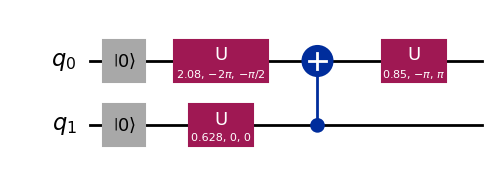

In [13]:
qc = qc.assign_parameters(x_train[0])
print(x_train[0])
qc.decompose().decompose().decompose().decompose().decompose().decompose().draw('mpl')

In [14]:
# Ce circuit quantique donne bel et bien le bon état!
Statevector.from_instruction(qc)

Statevector([0.776114  +0.j, 0.54974742+0.j, 0.30721179+0.j,
             0.03233808+0.j],
            dims=(2, 2))


### Encodage à l'aide de Qiskit




Qiskit offre différentes classes qui implémentent des projections dans l'espace des caractéristiques quantiques, notamment `ZFeatureMap`, `ZZFeatureMap` et `PauliFeatureMap`.<br>
On peut visualiser les circuits correspondants.

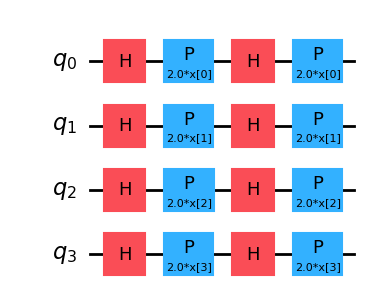

In [15]:
map_z = ZFeatureMap(feature_dimension=nb_features, reps = 2)
map_z.decompose().draw('mpl')

Ici la [porte P](https://qiskit.org/documentation/stubs/qiskit.circuit.library.PhaseGate.html) est la porte de phase, une rotation autour de l'axe $Z$. 

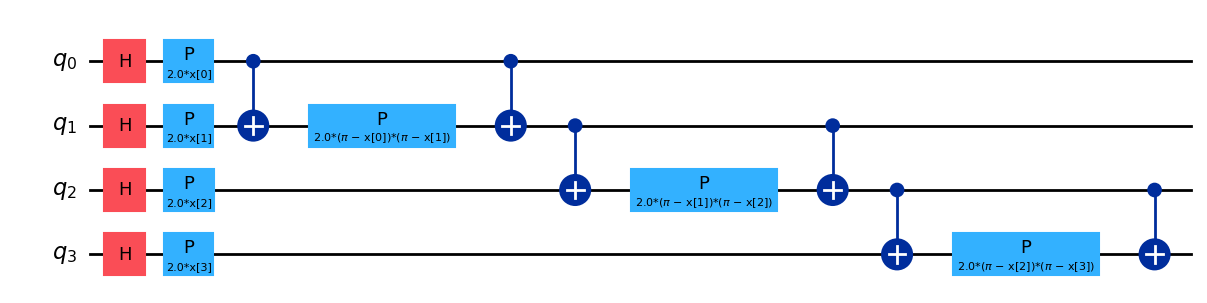

In [16]:
map_pauli = PauliFeatureMap(feature_dimension=4, reps=1, entanglement = 'linear')
map_pauli.decompose().draw('mpl')

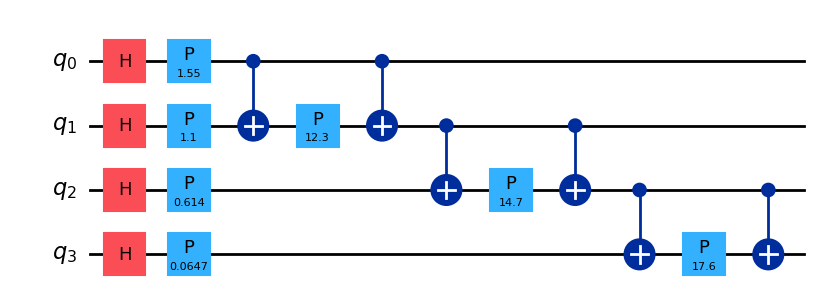

In [17]:
encode_circuit = map_pauli.assign_parameters(x_train[0])
encode_circuit.decompose().draw('mpl')

## Exercise 2
Encodez le vecteur $x = (-5, 4.5, 0.2, 1)$ en utilisant l'encodage `ZZFeatureMap`.

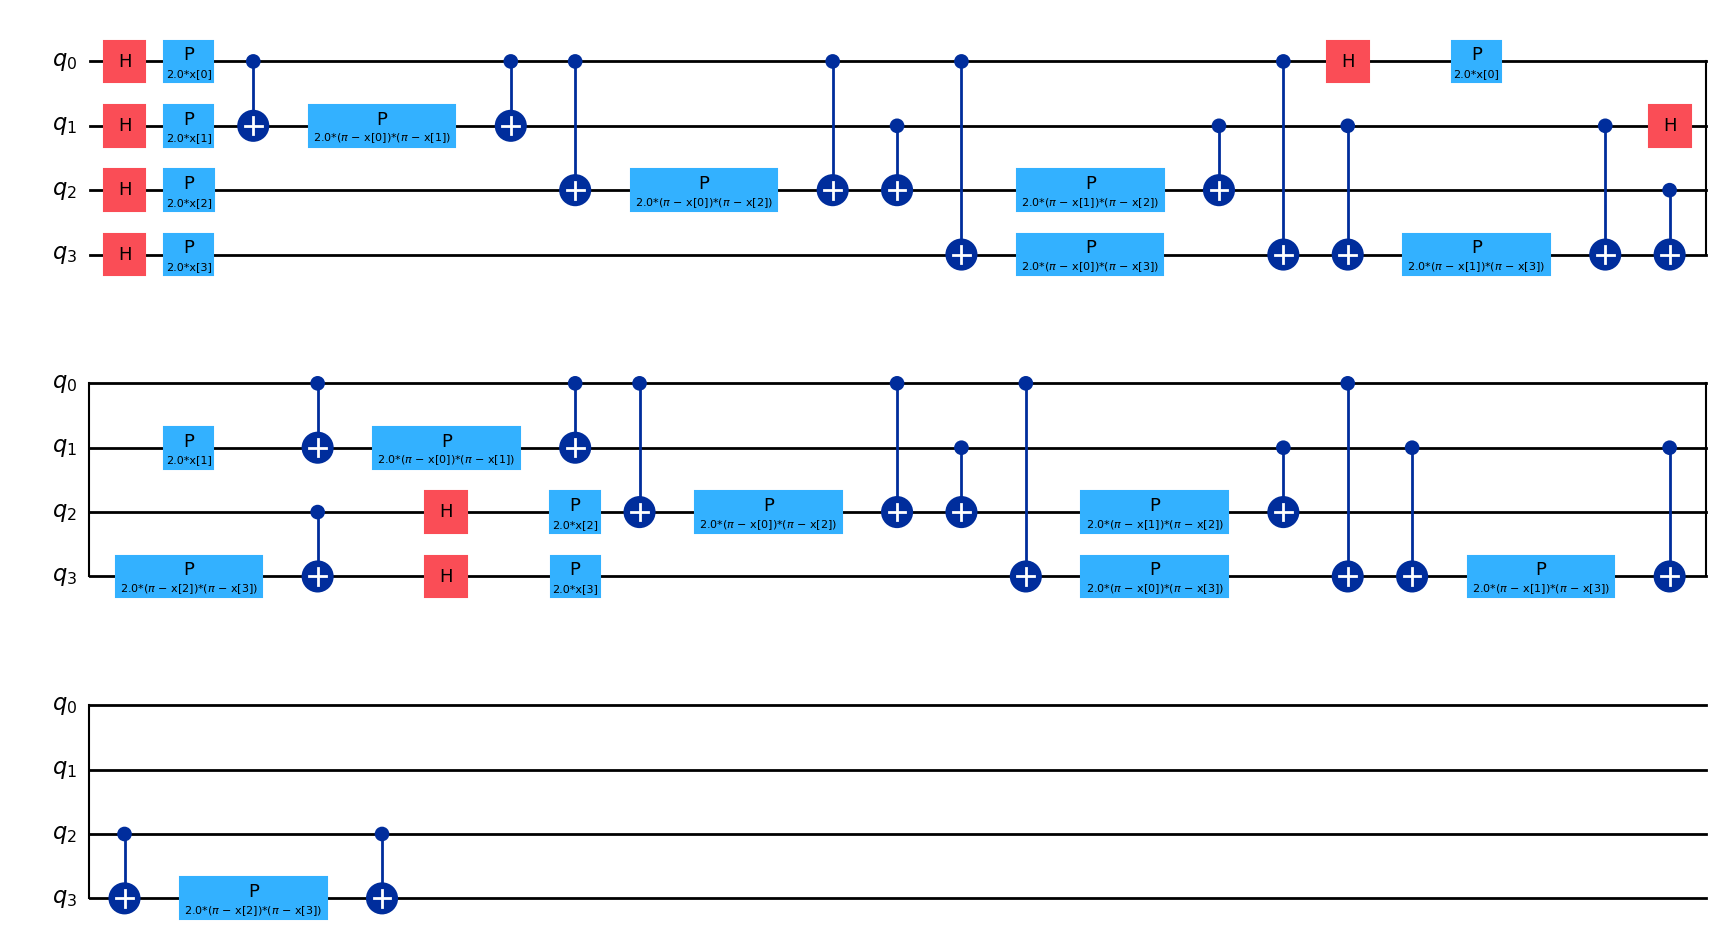

In [30]:
map_z = ZZFeatureMap(feature_dimension=nb_features, reps = 2)
map_z.decompose().draw('mpl')

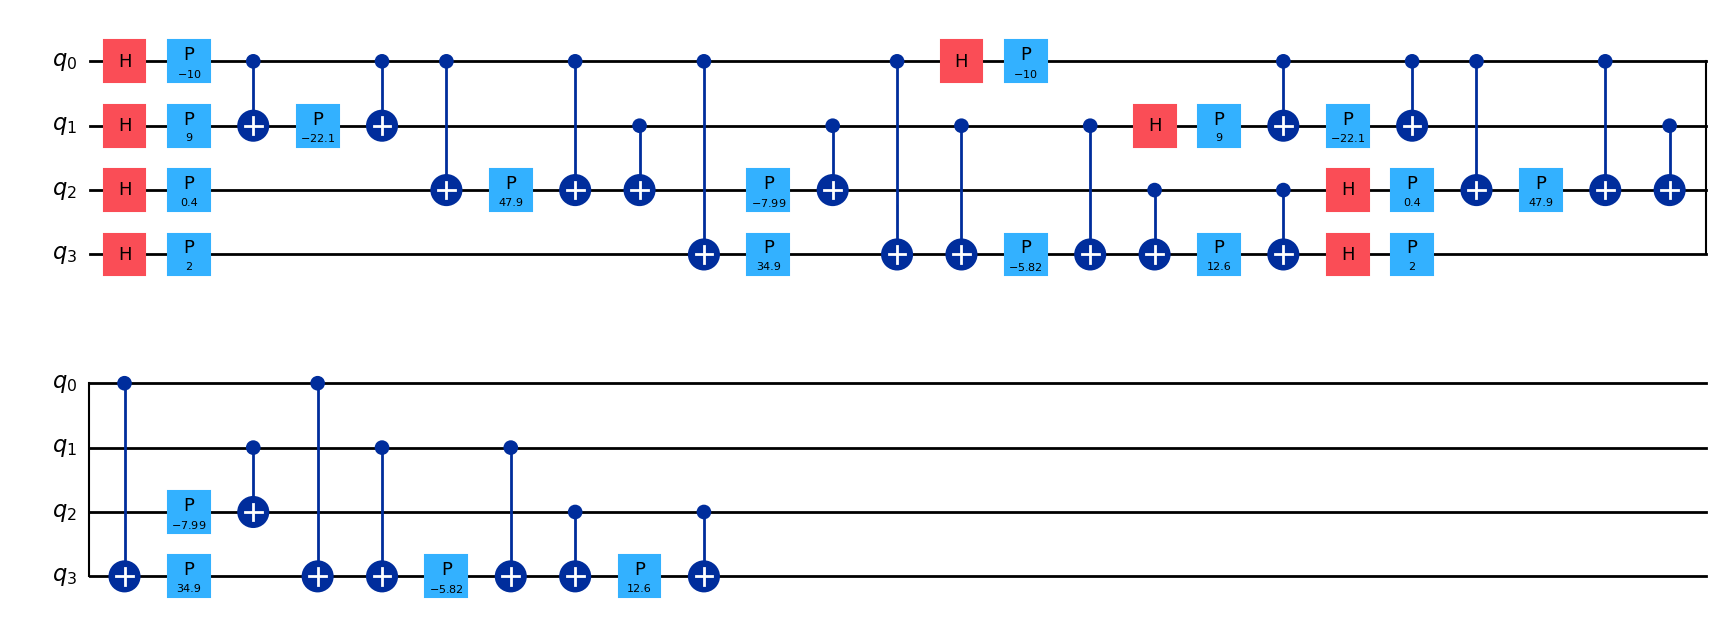

In [32]:
x = [-5, 4.5, 0.2, 1]

zz_circuit = ZZFeatureMap(4)
encoded_circuit = zz_circuit.assign_parameters(x)

encoded_circuit.decompose().draw('mpl')

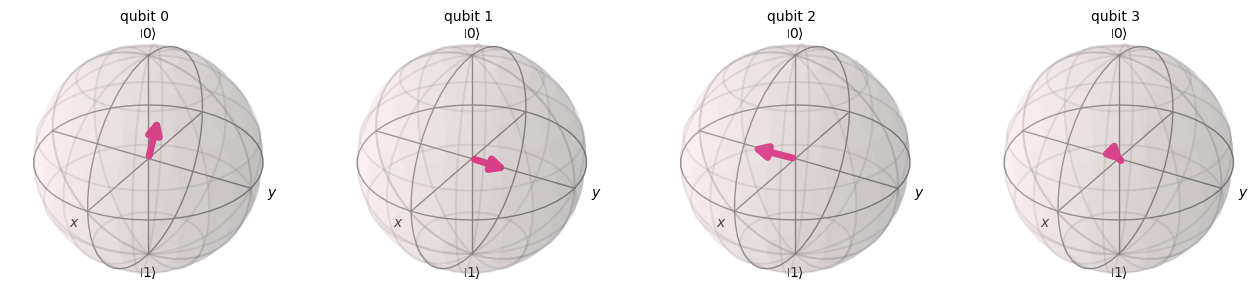

In [33]:
from qiskit_aer import Aer

simulator = Aer.get_backend('statevector_simulator')
state = Statevector(encoded_circuit)
state.draw('bloch')
